In [1]:
import numpy as np
import torch
import diffusers
import transformers
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

## Defining a pipeline

https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline

In [3]:
ddpm = diffusers.DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True)
# .to("cuda")
image = ddpm(num_inference_steps=25).images[0]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

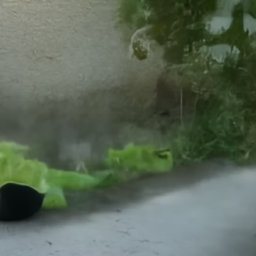

In [4]:
image

## Defining a pipeline with custom model and scheduler 

In [11]:
pretrained_model_name = "google/ddpm-cat-256"
device = "cpu"

# define model and scheduler
model = diffusers.UNet2DModel.from_pretrained(pretrained_model_name, use_safetensors=True).to(device)
scheduler = diffusers.DDPMScheduler.from_pretrained(pretrained_model_name)
scheduler.set_timesteps(50)

# define random noise with the same shape as output
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device=device)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [14]:
# predicting image at previous step using scheduler
input = noise
for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

# convert denoised image to output image
image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Denoised Image')

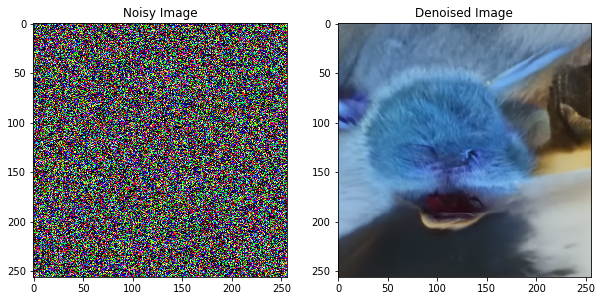

In [31]:
# show image before and after denoising

fig, axs = plt.subplots(1, 2, figsize=(10,5))

noisy_image = np.transpose(noise[0], (1, 2, 0))
axs[0].imshow(np.array(noisy_image), interpolation='nearest')
axs[0].set_title("Noisy Image")

axs[1].imshow(image, interpolation='nearest')
axs[1].set_title("Denoised Image")


## Defining a pipeline from Autoencoder, tokenizer, encoder, UnetConditionModel and Scheduler for Text2Image (inc)

https://huggingface.co/CompVis/stable-diffusion-v1-4

In [2]:
model_name = "CompVis/stable-diffusion-v1-4"

vae = diffusers.AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_safetensors=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, subfoler="tokenizer", use_fast=False)
# text_encoder = transformers.CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", use_safetensors=True)
unet = diffusers.UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_safetensors=True)
scheduler = diffusers.UniPCMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")

# set up cuda to speed up inference

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
# --- Create Text Embedding

prompt = ["a penguin holding a penguin toy in a desert"]
height, width = 512, 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(0)
batch_size = len(prompt)

# tokenize the text and generate embeddings from the prompt
text_input = tokenizer(prompt, padding="max_length", lax_length=tokenizer.model_max_length, truncation=True, 
                       return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to('cpu'))[0]

# generate unconditional text embeddings
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cpu'))[0]

# concatenate conditional and unconditional embedding
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


In [ ]:
# --- Create Image Embedding
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device='cpu'
)
latents = latents * scheduler.init_noise_sigma

# denoising the image
scheduler.set_timesteps(num_inference_steps)
for t in tqdm(scheduler.timesteps):
    # expand latents if we are doing classifier-free guidance to avoid doing foward pass
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute previous sample
    latents = scheduler.step(noise_pred, t, latents).prev_sample

## Text2Image from Pipeline (inc)

In [ ]:
# make sure you're logged in with `huggingface-cli login`
from torch import autocast
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
	"CompVis/stable-diffusion-v1-4", 
	use_auth_token=False
).to("cpu")

# prompt = "a photo of an astronaut riding a horse on mars"
# with autocast("cpu"):
#     image = pipe(prompt)["sample"][0]  
    
# image.save("astronaut_rides_horse.png")